# Step 0: Look at the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [3]:
df = pd.read_parquet('posts.parquet')

def int_to_bool_preserve_nan(x):
    return x if pd.isnull(x) else bool(x)
df['hit'] = df['hit'].apply(int_to_bool_preserve_nan)
df['vote'] = df['vote'].apply(int_to_bool_preserve_nan)

print('Total posts:', len(df))
print('Total posts voted on:', len(df[df['vote'].notnull()]))
df.head()

Total posts: 20004
Total posts voted on: 18109


,id,title,body,submitter,utc_time,flair,hit,vote
0,137402k,LF tandemaus w/3-4 iv's,,KaiserGora,2023-05-04 00:03:20+00:00,SV,NaN,False
1,137b1wz,LF Quaxley FT Sprigatito or Crocalor,"I got these two from surprise trade, can’t get...",YSoSidious,2023-05-04 05:27:36+00:00,SV (Closed),NaN,False
2,137bklj,Scarlet and Violet Daily Casual Trade Thread f...,# Welcome to the /r/pokemontrades Scarlet and ...,Porygon-Bot,2023-05-04 05:55:09+00:00,Daily,NaN,False
3,137bo30,Daily Discussion &amp; Question Thread for 04 ...,# Welcome to the Daily Discussion &amp; Questi...,Porygon-Bot,2023-05-04 06:00:10+00:00,Daily,NaN,False
4,137d45k,LF Oranguru and Stonjourner FT all violet excl...,"Hey all, i’m just 2 mons away from completing ...",Virtual-Point,2023-05-04 07:20:21+00:00,SV (Closed),NaN,False


# Step 1: Retrain the model

In [5]:
import re
import unidecode

def cleanup(text):
    # convert to ASCII
    text = unidecode.unidecode(text, errors='ignore')
    # remove Markdown links
    text = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', text)
    # split on spaces
    words = text.split()
    # remove links (heuristically)
    words = [w for w in words if not w.startswith('http') and not w.startswith('www')]
    # convert curly double/single quotes to plain single quotes
    words = [w.replace('“', "'").replace('”', "'").replace('‘', "'").replace('’', "'") for w in words]
    # split on other punctuation (except apostrophes and hyphens) and convert to lowercase
    words = [w for word in words for w in re.split(r"[^A-Za-z0-9'-]+", word.lower())]
    # remove any remaining punctuation
    words = [re.sub(r"[^A-Za-z0-9]", '', w) for w in words]
    # get rid of anything that doesn't have at least one letter
    words = [s for s in words if any(c.isalpha() for c in s)]
    # string back together
    return ' '.join(words)

df_voted_processed = (df.assign(title=df.title.apply(cleanup))
                      .assign(body=df.body.apply(cleanup))
                      .assign(post=lambda df: df.title + ' ' + df.body)
                      .loc[df['vote'].notnull(), ['id', 'title', 'body', 'post', 'vote']])
df_voted_processed.head()

,id,title,body,post,vote
0,137402k,lf tandemaus w ivs,,lf tandemaus w ivs,False
1,137b1wz,lf quaxley ft sprigatito or crocalor,i got these two from surprise trade cant get l...,lf quaxley ft sprigatito or crocalor i got the...,False
2,137bklj,scarlet and violet daily casual trade thread f...,welcome to the r pokemontrades scarlet and vio...,scarlet and violet daily casual trade thread f...,False
3,137bo30,daily discussion amp question thread for may,welcome to the daily discussion amp question t...,daily discussion amp question thread for may w...,False
4,137d45k,lf oranguru and stonjourner ft all violet excl...,hey all im just mons away from completing the ...,lf oranguru and stonjourner ft all violet excl...,False


## Train-test split

In this case, we'll use the 'test set' in Step 2 of this notebook, i.e. to determine the probability thresholds for manual assignment.

In [9]:
from sklearn.model_selection import train_test_split

y_true = df_voted_processed.vote.to_numpy().astype(int)
X_train, X_test, y_train, y_test = train_test_split(df_voted_processed, y_true, test_size=0.2, random_state=468)

# Check that the train/test split is balanced.
print(f"1's in training set : {np.count_nonzero(y_train)} out of {len(y_train)} ({np.count_nonzero(y_train) / len(y_train):.2%})")
print(f"1's in test set     : {np.count_nonzero(y_test)} out of {len(y_test)} ({np.count_nonzero(y_test) / len(y_test):.2%})")

1's in training set : 2707 out of 14487 (18.69%)
1's in test set     : 692 out of 3622 (19.11%)


In [5]:
# General setup

from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix

def cv(pipeline, k=5, plot=False):
    cv = cross_validate(pipeline, X_train, y_train, cv=k, scoring='f1',
                        return_estimator=plot, return_indices=plot)
    if plot: 
        # Get predictions from the estimator that was returned. This is slightly
        # inefficient, but still better than calling cross_val_score and then
        # cross_val_predict, which does the CV twice for no reason.
        y_pred = np.array([])
        y_true = np.array([])
        indices = np.array([])
        for i in range(k):
            estimator = cv['estimator'][i]
            test_indices = cv['indices']['test'][i]
            this_y_pred = estimator.predict(X_train.iloc[test_indices])
            this_y_train = y_train[test_indices]
            indices = np.concatenate((indices, test_indices))
            y_pred = np.concatenate((y_pred, this_y_pred))
            y_true = np.concatenate((y_true, this_y_train))
        # Plot confusion matrix
        _, ax = plt.subplots(figsize=(5, 5))
        ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(ax=ax)
        ax.set_title(f'CV F1 : {np.mean(cv["test_score"]):.4%}')
    # Return CV results
    return cv

{'clf__max_depth': 7, 'clf__n_estimators': 400}


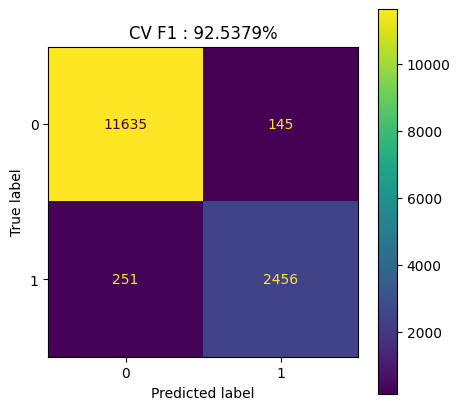

In [14]:
# Grid search CV for the best XGBoost parameters

from sklearn.model_selection import GridSearchCV

xg = Pipeline([
    ('vec', ColumnTransformer([("post", CountVectorizer(ngram_range=(1, 2), max_features=5000), "post")])),
    ('clf', xgb.XGBClassifier(max_depth=7, n_estimators=200, objective='binary:logistic', )),
])

xg_grid = GridSearchCV(estimator=xg,
                       param_grid={
                            'clf__max_depth': [3, 5, 7, 9],
                            'clf__n_estimators': [100, 200, 400],
                       },
                       scoring='f1')
xg_grid.fit(X_train, y_train)

print(xg_grid.best_params_)

best_xg = xg_grid.best_estimator_
cv_best_xg = cv(best_xg, plot=True)

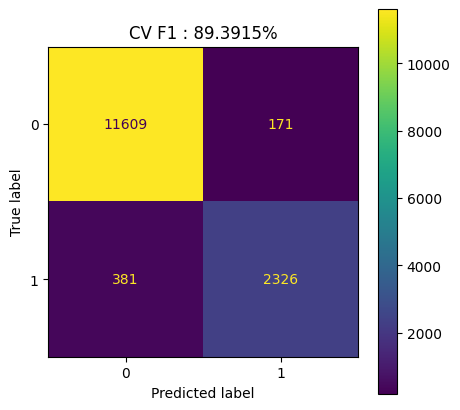

In [7]:
from sklearn.linear_model import LogisticRegression

lr = Pipeline([
    ('vec', ColumnTransformer([("post", CountVectorizer(ngram_range=(1, 2), max_features=5000), "post")])),
    ('clf', LogisticRegression(max_iter=5000)),
])
cv_lr = cv(lr, plot=True)

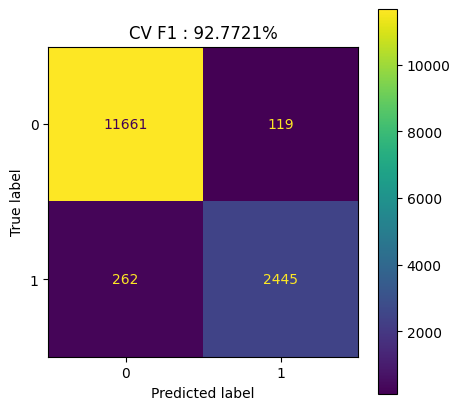

In [8]:
from sklearn.ensemble import StackingClassifier

stacked_xg_lr = StackingClassifier(
    estimators=[
        ('xg', xg),
        ('lr', lr),
    ],
    final_estimator=LogisticRegression(max_iter=5000)
)

cv_stacked = cv(stacked_xg_lr, plot=True)

In [15]:
stacked_grid = GridSearchCV(estimator=stacked_xg_lr,
                            param_grid={
                                'xg__clf__max_depth': [3, 5, 7, 9],
                                'xg__clf__n_estimators': [100, 200, 400],
                                'xg__vec__post__max_features': [2500, 5000, 10000],
                                'lr__vec__post__max_features': [2500, 5000, 10000],
                            },
                            scoring='f1')
stacked_grid.fit(X_train, y_train)

GridSearchCV(estimator=StackingClassifier(estimators=[('xg',
                                                       Pipeline(steps=[('vec',
                                                                        ColumnTransformer(transformers=[('post',
                                                                                                         CountVectorizer(max_features=5000,
                                                                                                                         ngram_range=(1,
                                                                                                                                      2)),
                                                                                                         'post')])),
                                                                       ('clf',
                                                                        XGBClassifier(base_score=None,
                                                                                      booster=None,
                                                                                      callbacks=None,
                                                                                      colsample_bylevel=None,
                                                                                      colsample_bynode=None,
                                                                                      colsample_bytree=None,
                                                                                      early_stopping_rounds=None,
                                                                                      enab...
                                                                                                         CountVectorizer(max_features=5000,
                                                                                                                         ngram_range=(1,
                                                                                                                                      2)),
                                                                                                         'post')])),
                                                                       ('clf',
                                                                        LogisticRegression(max_iter=5000))]))],
                                          final_estimator=LogisticRegression(max_iter=5000)),
             param_grid={'lr__vec__post__max_features': [2500, 5000, 10000],
                         'xg__clf__max_depth': [3, 5, 7, 9],
                         'xg__clf__n_estimators': [100, 200, 400],
                         'xg__vec__post__max_features': [2500, 5000, 10000]},
             scoring='f1')

{'lr__vec__post__max_features': 10000, 'xg__clf__max_depth': 9, 'xg__clf__n_estimators': 100, 'xg__vec__post__max_features': 10000}


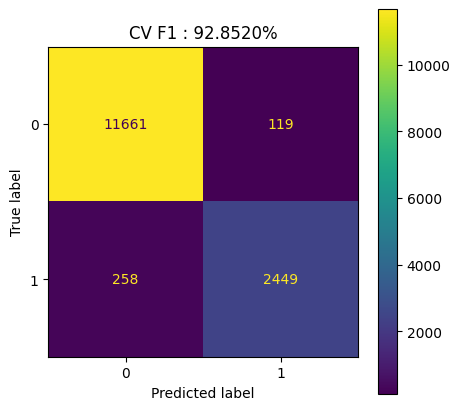

In [17]:
print(stacked_grid.best_params_)

_ = cv(stacked_grid.best_estimator_, plot=True)

In [36]:
# On test set

optimised_model = stacked_grid.best_estimator_

optimised_model.fit(X_train, y_train)
y_pred = optimised_model.predict(X_test)

_, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred)).plot(ax=ax)
ax.set_title(f'Test F1 : {f1_score(y_true=y_test, y_pred=y_pred):.4%}')
plt.show()

NameError: name 'stacked_grid' is not defined

In [21]:
joblib.dump(optimised_model, 'stacked_xg_lr_model_231017.joblib')

with open('training_post_ids.txt', 'w') as file:
    file.write('\n'.join(X_train.id.to_list())) 
with open('test_post_ids.txt', 'w') as file:
    file.write('\n'.join(X_test.id.to_list())) 

# Step 2: Determine threshold for manual assignment

In [19]:
optimised_model = joblib.load('stacked_xg_lr_model_231017.joblib')

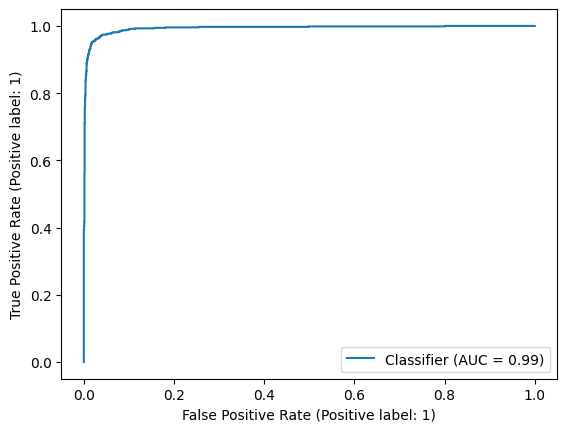

In [20]:
y_probs_pred = optimised_model.predict_proba(X_test)[:, 1]   # Indexing to get the probability of a 1

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_probs_pred)

## What threshold to use for negatives?

If we unconditionally reject all posts with a score below $p_n$, what percentage of positives do we miss?

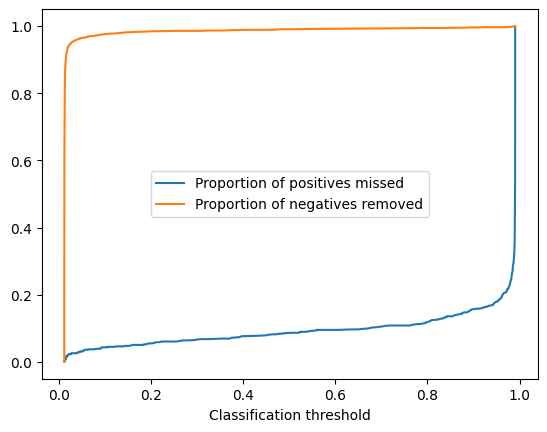

In [21]:
probas = np.unique(y_probs_pred)

def positives_missed_at(threshold):
    total_positives = np.count_nonzero(y_test)
    return np.count_nonzero((y_test == 1) & (y_probs_pred < threshold)) / total_positives

def negatives_removed_at(threshold):
    total_negatives = len(y_test) - np.count_nonzero(y_test)
    return np.count_nonzero((y_test == 0) & (y_probs_pred < threshold)) / total_negatives

positives_missed = [positives_missed_at(threshold) for threshold in probas]
negatives_removed = [negatives_removed_at(threshold) for threshold in probas]

plt.plot(probas, positives_missed, label='Proportion of positives missed')
plt.plot(probas, negatives_removed, label='Proportion of negatives removed')
plt.xlabel('Classification threshold')
plt.legend()
plt.show()

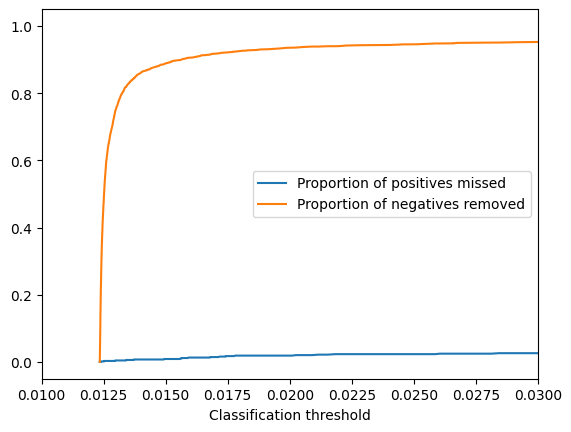

In [22]:
# Zooming in...
plt.plot(probas, positives_missed, label='Proportion of positives missed')
plt.plot(probas, negatives_removed, label='Proportion of negatives removed')
plt.xlabel('Classification threshold')
plt.legend()
plt.xlim(0.01, 0.03)
plt.show()

In [23]:
THRESHOLD = 0.015

print(f'Proportion of positives missed: {positives_missed_at(THRESHOLD):.2%}')
print(f'Proportion of negatives removed: {negatives_removed_at(THRESHOLD):.2%}')

Proportion of positives missed: 0.87%
Proportion of negatives removed: 88.84%


How about the positive filter?

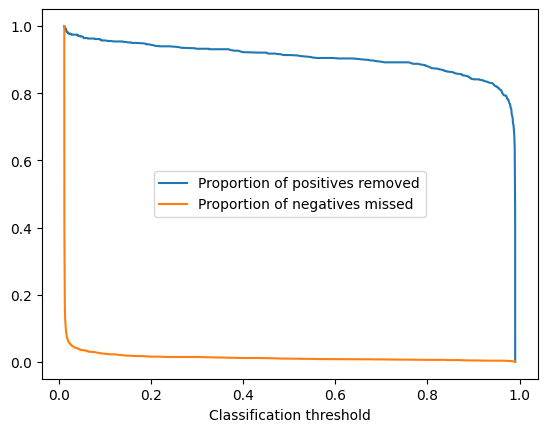

In [24]:
def positives_removed_at(threshold):
    total_positives = np.count_nonzero(y_test)
    return np.count_nonzero((y_test == 1) & (y_probs_pred > threshold)) / total_positives

def negatives_missed_at(threshold):
    total_negatives = len(y_test) - np.count_nonzero(y_test)
    return np.count_nonzero((y_test == 0) & (y_probs_pred > threshold)) / total_negatives

positives_removed = [positives_removed_at(threshold) for threshold in probas]
negatives_missed = [negatives_missed_at(threshold) for threshold in probas]

plt.plot(probas, positives_removed, label='Proportion of positives removed')
plt.plot(probas, negatives_missed, label='Proportion of negatives missed')
plt.xlabel('Classification threshold')
plt.legend()
plt.show()

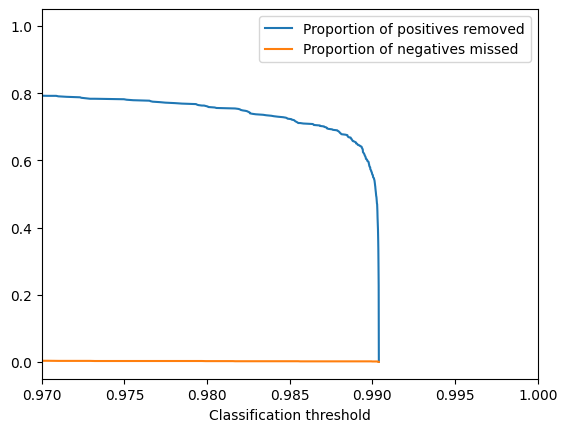

In [25]:
plt.plot(probas, positives_removed, label='Proportion of positives removed')
plt.plot(probas, negatives_missed, label='Proportion of negatives missed')
plt.xlabel('Classification threshold')
plt.xlim(0.97, 1.00)
plt.legend()
plt.show()

I think it's not really worth implementing this.
People probably don't mind _confirming_ that Aprimon posts are Aprimon posts.
It's the deluge of negatives that is really annoying.

SUMMARY: For any post with a probability < 0.015 we automatically reject it (maybe by outputting `-1`) and do not send it to the website for manual review.

# Mark new posts below probability threshold as not needing review

In [26]:
df_voted_unprocessed = (df.assign(title=df.title.apply(cleanup))
                      .assign(body=df.body.apply(cleanup))
                      .assign(post=lambda df: df.title + ' ' + df.body)
                      .loc[df['vote'].isnull(), ['id', 'title', 'body', 'post', 'vote']])
df_voted_unprocessed.head()

,id,title,body,post,vote
18109,16xcg7a,lf hzoroark codes ft events shiny marked pokes,hello i am looking hzoroark codes i can offer ...,lf hzoroark codes ft events shiny marked pokes...,NaN
18110,16xchdr,lf aipom amp morpeko ft gligar amp cramorant o...,,lf aipom amp morpeko ft gligar amp cramorant o...,NaN
18111,16xcu5l,lf drampa and or oranguru ft other exclusives ...,hi everyone i need drampa and oranguru for my ...,lf drampa and or oranguru ft other exclusives ...,NaN
18112,16xd02i,scarlet exclusives pt1,status active hello poke fans this post will b...,scarlet exclusives pt1 status active hello pok...,NaN
18113,16xd6ez,trade evo in scarlet,need help evolving my feebas i have the prism ...,trade evo in scarlet need help evolving my fee...,NaN


In [27]:
optimised_model = joblib.load('stacked_xg_lr_model_231017.joblib')

df_voted_unprocessed['proba'] = optimised_model.predict_proba(df_voted_unprocessed)[:, 1]

df_voted_unprocessed.head()

,id,title,body,post,vote,proba
18109,16xcg7a,lf hzoroark codes ft events shiny marked pokes,hello i am looking hzoroark codes i can offer ...,lf hzoroark codes ft events shiny marked pokes...,NaN,0.012350
18110,16xchdr,lf aipom amp morpeko ft gligar amp cramorant o...,,lf aipom amp morpeko ft gligar amp cramorant o...,NaN,0.013851
18111,16xcu5l,lf drampa and or oranguru ft other exclusives ...,hi everyone i need drampa and oranguru for my ...,lf drampa and or oranguru ft other exclusives ...,NaN,0.012751
18112,16xd02i,scarlet exclusives pt1,status active hello poke fans this post will b...,scarlet exclusives pt1 status active hello pok...,NaN,0.012891
18113,16xd6ez,trade evo in scarlet,need help evolving my feebas i have the prism ...,trade evo in scarlet need help evolving my fee...,NaN,0.012491


In [33]:
unneeded_ids = set(df_voted_unprocessed[df_voted_unprocessed['proba'] < THRESHOLD].id.to_list())
print(f'{len(unneeded_ids)} of {len(df_voted_unprocessed)} posts will be marked as not needing review.')

1332 of 1895 posts will be marked as not needing review.


In [34]:
comma_separated_ids = ", ".join(f"'{unneeded_id}'" for unneeded_id in unneeded_ids)
print(f"UPDATE posts SET needs_review = false WHERE id IN ({comma_separated_ids});")

UPDATE posts SET needs_review = false WHERE id IN ('1785dbq', '16y3u0s', '16znf1t', '170x90g', '179lbr2', '1733qyb', '175lb56', '16y7h3f', '17400u5', '1756fj5', '179l15o', '178hywh', '171triv', '173tzzn', '16zdjwz', '16y14zo', '16ze157', '16yk11k', '177lg6v', '1741yne', '1779ako', '172o5kq', '172xxs3', '178z5co', '176krva', '174xbbw', '172fco4', '178fvbo', '1713bqp', '17a07hn', '176jxyw', '172o62z', '179rdmb', '17029k9', '16xcg7a', '16zufqm', '179ifi4', '16z4jox', '1770g2d', '179ol7z', '179nbmp', '1776ec5', '171s8sw', '16yzwgx', '178avyx', '178q3ff', '170lxoo', '16zv0is', '179rfs4', '174fumf', '1731l43', '173314r', '170u5xn', '173kglk', '172dpij', '175ut1b', '173g0jd', '1721cx2', '16ywk9q', '175qg6a', '171rrma', '172ngum', '173vj9a', '17974ak', '17707qi', '179ta8x', '175h8uv', '177089p', '177rvt5', '171hrci', '178v1en', '16z7tjc', '171iv5h', '16yxalm', '16xytfk', '175pf4t', '176w61y', '177kz5r', '16y1c44', '16yxtys', '177579u', '1727wqs', '173ith6', '174y8ii', '1781igz', '1788tgq', '17